# Analying CIA Factbook Data Using SQL

- Install ipython-sql using if never installed before:<br>
    _!conda install -yc conda-forge ipython-sql_

In [3]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [9]:
%%sql
SELECT *
FROM sqlite_master;

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


## Overview of the Data

In [10]:
%%sql
SELECT *
FROM facts
LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for each of the columns:
- name - The name of the country.
- area_land - The country's land area in square kilometers.
- area_water - The country's waterarea in square kilometers.
- population - The country's population.
- population_growth- The country's population growth as a percentage.
- birth_rate - The country's birth rate, or the number of births a year per 1,000 people.
- death_rate - The country's death rate, or the number of death a year per 1,000 people.

## Summary statistics to look for outlier countries

In [11]:
%%sql
SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth)
FROM facts;

 * sqlite:///factbook.db
Done.


MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,7256490011,0.0,4.02


From the summary statistics, we can see there is at least one country with no population and one/more country with > 7.2 billion people. These values seem odd, so let's check on those specific countries.

In [14]:
%%sql
SELECT *
FROM facts
WHERE population == (SELECT MIN(population)
                    FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


The zero population belongs to Antarctica, which seems match the CIA Factbook [page for Antarctica](https://www.cia.gov/library/publications/the-world-factbook/geos/ay.html). 
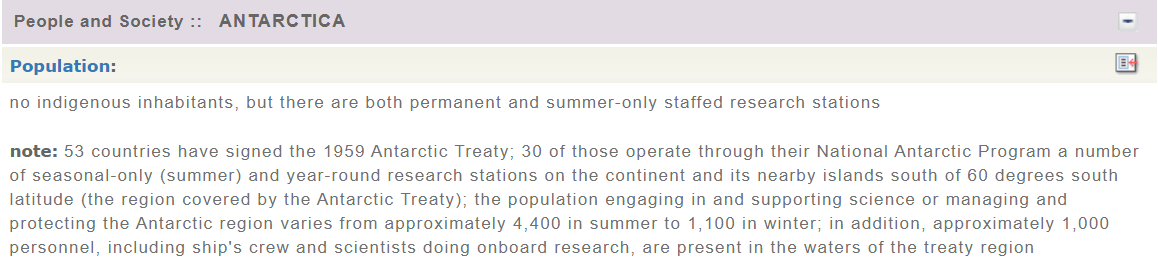

In [15]:
%%sql
SELECT *
FROM facts
WHERE population == (SELECT MAX(population)
                    FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


Alright, the minimum population belongs to the Antarctica and maximum population is the whole world population. Now, we need to recompute summary statistics without those rows.

In [17]:
%%sql
SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth)
FROM facts
WHERE (population != (SELECT MIN(population)
                    FROM facts))
AND (population != (SELECT MAX(population)
                   FROM facts));

 * sqlite:///factbook.db
Done.


MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
48,1367485388,0.0,4.02


Now let's check the average of population and area of a coutry.

In [20]:
%%sql
SELECT AVG(population), AVG(area)
FROM facts
WHERE (population != (SELECT MIN(population)
                    FROM facts))
AND (population != (SELECT MAX(population)
                   FROM facts));

 * sqlite:///factbook.db
Done.


AVG(population),AVG(area)
32377011.0125,582949.8523206752


What countries are densely populated? Need to meet the follwing two conditions:
- Above average value for population.
- Below average values for area.

We use population density, population/area, as the index. The higher the value the country is denser in population.

In [26]:
%%sql
SELECT name, population, area, ROUND(CAST(population AS FLOAT)/area, 2) AS Population_Density
FROM facts
WHERE (population > (SELECT AVG(population)
                    FROM facts))
AND (area < (SELECT AVG(area)
                    FROM facts))
ORDER BY Population_Density DESC;

 * sqlite:///factbook.db
Done.


name,population,area,Population_Density
Bangladesh,168957745,148460,1138.07
Philippines,100998376,300000,336.66
Japan,126919659,377915,335.84
Vietnam,94348835,331210,284.86
United Kingdom,64088222,243610,263.08
Germany,80854408,357022,226.47
Thailand,67976405,513120,132.48


It is not surprising that Bangladesh, Philippines, and Japan are the top 3 densely populated countries. You also may notice that 5 out 7 most densely populated countries are in Asia. 